# 패키지 및 데이터 임포트

데이터 출처: https://www.kaggle.com/loveall/appliances-energy-prediction

In [ ]:
! pip install neuralprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 103 kB 24.1 MB/s 
     |████████████████████████████████| 1.6 MB 36.9 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.5 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
spacy 3.4.3 requires typing-extensions<4.2.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
confection 0.0.3 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incom

In [ ]:
#패키지 임포트
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
import plotly.express as px
set_log_level("ERROR")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_excel('/content/drive/MyDrive/공모전/전처리결과.xlsx')

In [ ]:
data.tail()

,Date,거리두기단계,누적확진자수,매출액
27,2022-05-01,-0.154151,0.065728,0.077521
28,2022-06-01,0.000000,-0.012992,0.088289
29,2022-07-01,0.000000,0.132097,0.076199
30,2022-08-01,0.000000,0.122126,0.100647
31,2022-09-01,0.000000,0.017933,0.083335


In [ ]:
data.describe()

,거리두기단계,누적확진자수,매출액
count,3.200000e+01,32.000000,32.000000
mean,-2.081668e-17,0.414589,0.036716
std,4.077894e-01,0.538481,0.075297
min,-1.299283e+00,-0.012992,-0.145147
25%,0.000000e+00,0.152606,0.005564
50%,0.000000e+00,0.236717,0.055036
75%,0.000000e+00,0.373880,0.084574
max,1.119890e+00,2.748237,0.161514


# 데이터 전처리 및 모델 학습

In [ ]:
#데이터 칼럼 확인
data.columns

Index(['Date', '거리두기단계', '누적확진자수', '매출액'], dtype='object')

In [ ]:
#시계열 및 종속변수 이름 변경
data = data.rename(columns={"Date":"ds","매출액":"y"})

In [ ]:
x_col_list=['누적확진자수','거리두기단계'] # X변수 정의
y_col_list=['y'] # Y변수 정의 

X=data[x_col_list]
Y=data[y_col_list]

X_diff=X.diff()
X_diff.columns=X.columns+'_diff'

#X_diff2=X.diff(periods=2)
#X_diff2.columns=X.columns+'_diff2'

#Y변수들에 대한 lag 데이터 생성 (2 lag 까지만)
Y_diff=Y.diff()
Y_diff.columns=Y.columns+'_diff'

#Y_diff2=Y.diff(periods=2)
#Y_diff2.columns=Y.columns+'_diff2'

#X데이터 결합
#X=pd.concat([X,X_diff,X_diff2],axis=1)
X=pd.concat([X,X_diff],axis=1)
#Y데이터 결합
#Y=pd.concat([Y,Y_diff,Y_diff2],axis=1)
Y=pd.concat([Y,Y_diff],axis=1)
#전체 데이터셋 생성
data_pret=pd.concat([data['ds'][2:],X,Y],axis=1)
data_pret=data_pret.reset_index(drop=True)
data_pret=data_pret.dropna()


In [ ]:
data_pret.head(5)

,ds,누적확진자수,거리두기단계,누적확진자수_diff,거리두기단계_diff,y,y_diff
2,2020-04-01,0.241231,0.528578,-1.139202,-0.242128,-0.145147,-0.040392
3,2020-05-01,0.392918,-1.299283,0.151688,-1.827861,-0.051623,0.093524
4,2020-06-01,0.322547,0.000000,-0.070372,1.299283,0.052247,0.103870
5,2020-07-01,0.270622,0.000000,-0.051924,0.000000,0.046239,-0.006008
6,2020-08-01,0.861506,1.119890,0.590883,1.119890,-0.086165,-0.132404


In [ ]:
#독립변수 정의
col_lst=data_pret.columns
col_lst=col_lst.drop(['ds','y'])
col_lst=list(col_lst)
col_lst

['누적확진자수', '거리두기단계', '누적확진자수_diff', '거리두기단계_diff', 'y_diff']

In [ ]:
#train test split
cutoff = "2021-10-01" #데이터 분할 기준
train = data_pret[data_pret['ds']<cutoff]
test = data_pret[data_pret['ds']>=cutoff]

In [ ]:
m = NeuralProphet(
    n_forecasts=10, 
    n_changepoints=3,
    n_lags=1, #1시간 뒤 regressor 지연 반영
    yearly_seasonality=30,
    num_hidden_layers=16, #히든 레이어 수 설정
    d_hidden=256, #은닉층 뉴런 설정
    learning_rate=0.01, #학습률 설정
    batch_size=4, #배치 사이즈 설정
    epochs=200, #학습 횟수
    drop_missing= True
)

m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

#독립 변인(변수) 추가 및 정규화
m = m.add_lagged_regressor(names=col_lst,normalize="minmax") 

#학습 수행
metrics = m.fit(train, freq="M", validation_df=test, progress='plot')


In [ ]:
metrics.tail(3) 

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
197,7.090314e-11,0.000002,0.000003,5.263707e-11,0.0,0.023366,0.042951,0.057914
198,7.089681e-11,0.000002,0.000003,5.261571e-11,0.0,0.023366,0.042951,0.057914
199,7.069932e-11,0.000002,0.000003,5.248194e-11,0.0,0.023366,0.042951,0.057914


In [ ]:
#metric 확인
print("SmoothL1Loss: ", metrics.SmoothL1Loss.tail(1).item())
print("MAE(Train): ", metrics.MAE.tail(1).item())
print("MAE(Test): ", metrics.MAE_val.tail(1).item())

SmoothL1Loss:  7.069932139724955e-11
MAE(Train):  2.47173011302948e-06
MAE(Test):  0.0429505929350853


In [ ]:
#학습 선 그래프 생성
px.line(metrics, y=['MAE', 'MAE_val'], width=800, height=400)

# 시각화 검증

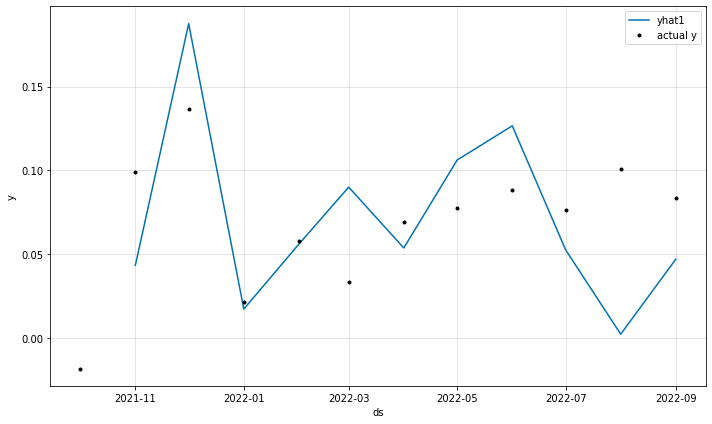

In [ ]:
#yhat1과 실제값 시각화
forecast = m.predict(test)
fig = m.plot(forecast[['ds', 'y', 'yhat1']])

In [ ]:
#예측 결과 데이터 shape
forecast.shape

(12, 85)

In [ ]:
forecast.tail()

,ds,y,residual1,yhat1,residual2,yhat2,residual3,yhat3,residual4,yhat4,...,lagged_regressor_y_diff4,lagged_regressor_y_diff5,lagged_regressor_y_diff6,lagged_regressor_y_diff7,lagged_regressor_y_diff8,lagged_regressor_y_diff9,lagged_regressor_y_diff10,trend,season_yearly,season_monthly
7,2022-05-01,0.077521,0.123637,0.201157,-0.004476,0.073045,-0.134112,-0.056592,-0.030153,0.047367,...,0.013216,0.010498,0.132457,0.004026,None,None,None,0.092955,-0.091653,0.020639
8,2022-06-01,0.088289,0.061833,0.150121,0.039449,0.127738,-0.05464,0.033649,0.39635,0.484639,...,0.059493,0.002318,0.094085,0.024797,0.002492,None,None,0.094515,-0.033754,0.022989
9,2022-07-01,0.076199,-0.175524,-0.099325,-0.116304,-0.040105,-0.213359,-0.137159,0.304129,0.380329,...,0.040971,0.010437,0.020777,0.017613,0.015349,0.016077,None,0.096024,-0.196998,0.020639
10,2022-08-01,0.100647,-0.15203,-0.051383,-0.115009,-0.014362,-0.187235,-0.086588,0.072264,0.172911,...,0.059284,0.007187,0.093534,0.00389,0.010902,0.099031,0.033653,0.097584,-0.14924,0.022989
11,2022-09-01,0.083335,-0.032642,0.050693,-0.032151,0.051184,-0.218825,-0.135489,-0.078194,0.005141,...,0.050928,0.0104,0.064414,0.01751,0.002408,0.070343,0.207295,0.099144,-0.071792,0.010712


In [ ]:
#예측 결과 확인
forecast.to_excel('예측2.xlsx')

In [ ]:
#잔차분석


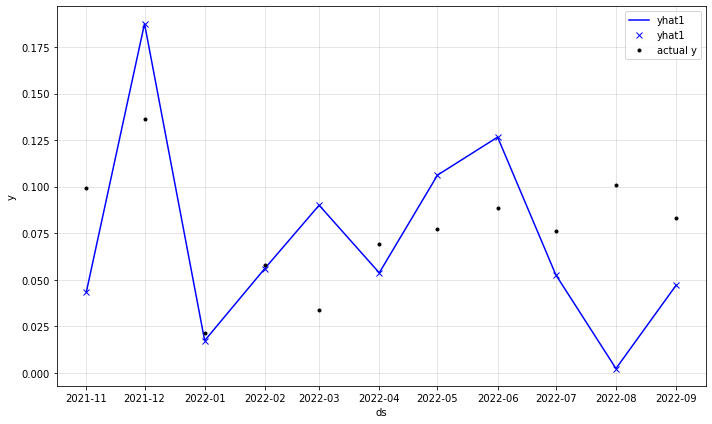

In [ ]:
forecast = m.predict(test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[-11:]) #1년간 데이터 확인

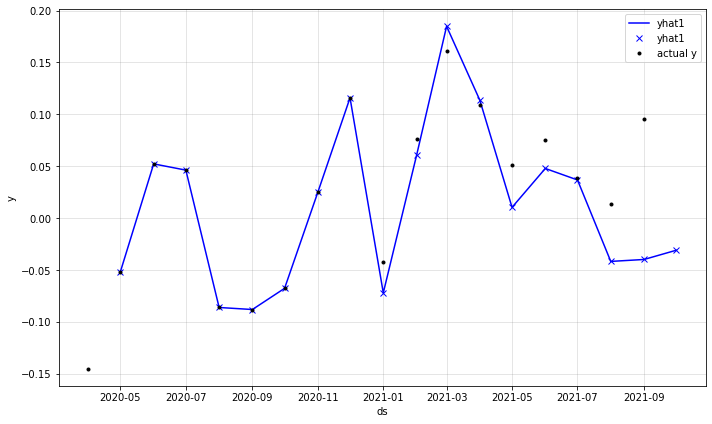

In [ ]:
future = m.make_future_dataframe(train, periods=15, n_historic_predictions=len(train))
forecast = m.predict(future)
fig_forecast = m.plot(forecast)